CHARGEMENT DES DONNEES

In [1324]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fanalysis.ca import CA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector
import joblib
import warnings

In [1325]:
REGRESSION_LOGISTIQUE = 'REGRESSION LOGISTIQUE'
ARBRE_DECISION = 'ARBRE DE DECISION'
SVM = 'SUPPORT VECTEUR MACHINE'

In [1326]:


df = pd.read_excel("PCOS_data_without_infertility.xlsx", sheet_name='Full_new', header=0, index_col=0)

print(df.head(10))

        Patient File No.  PCOS (Y/N)   Age (yrs)  Weight (Kg)  Height(Cm)   \
Sl. No                                                                       
1                      1           0          28         44.6        152.0   
2                      2           0          36         65.0        161.5   
3                      3           1          33         68.8        165.0   
4                      4           0          37         65.0        148.0   
5                      5           0          25         52.0        161.0   
6                      6           0          36         74.1        165.0   
7                      7           0          34         64.0        156.0   
8                      8           0          33         58.5        159.0   
9                      9           0          32         40.0        158.0   
10                    10           0          36         52.0        150.0   

         BMI  Blood Group  Pulse rate(bpm)   RR (breaths/min)  

In [1327]:
print(df.info())
print(f"Nombre de lignes et de colonnes: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 1 to 541
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Patient File No.        541 non-null    int64  
 1   PCOS (Y/N)              541 non-null    int64  
 2    Age (yrs)              541 non-null    int64  
 3   Weight (Kg)             541 non-null    float64
 4   Height(Cm)              541 non-null    float64
 5   BMI                     242 non-null    float64
 6   Blood Group             541 non-null    int64  
 7   Pulse rate(bpm)         541 non-null    int64  
 8   RR (breaths/min)        541 non-null    int64  
 9   Hb(g/dl)                541 non-null    float64
 10  Cycle(R/I)              541 non-null    int64  
 11  Cycle length(days)      541 non-null    int64  
 12  Marraige Status (Yrs)   540 non-null    float64
 13  Pregnant(Y/N)           541 non-null    int64  
 14  No. of aborptions       541 non-null    int64  

# DEBUT DU NETTOYAGE

In [1328]:
df.columns = df.columns.str.strip()

#On vérifie les données erronnées
for col in df.columns:
    if df[col].dtype == object:
        print(f"Avant suppression : {col}: {df[col].dtype}")
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Après suppression : {col}: {df[col].dtype}")

Avant suppression : II    beta-HCG(mIU/mL): object
Après suppression : II    beta-HCG(mIU/mL): float64
Avant suppression : AMH(ng/mL): object
Après suppression : AMH(ng/mL): float64


In [1329]:
#On supprime les colonnes qui n'ont pas assez de valeurs
column_less_than_300 = df.columns[df.count() < 300].tolist()
print(f"Colonnes ayant moins de 300 enregistrement :{column_less_than_300}")
df = df.drop(columns=column_less_than_300)

Colonnes ayant moins de 300 enregistrement :['BMI', 'FSH/LH', 'Waist:Hip Ratio']


In [1330]:
#On a une colonne "Patient File No." qui est en doublon avec la colonne d'index et qui n'apporte rien à la detection de la maladie donc on la retire
df = df.drop(columns="Patient File No.")

In [1331]:
#On vérifie si on a des doublons
print(f"Nombres de lignes dupliquées : {df.duplicated().sum()}")

Nombres de lignes dupliquées : 0


In [1332]:
print(df.info())
print(f"Nombre de lignes et de colonnes: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
Index: 541 entries, 1 to 541
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              541 non-null    int64  
 1   Age (yrs)               541 non-null    int64  
 2   Weight (Kg)             541 non-null    float64
 3   Height(Cm)              541 non-null    float64
 4   Blood Group             541 non-null    int64  
 5   Pulse rate(bpm)         541 non-null    int64  
 6   RR (breaths/min)        541 non-null    int64  
 7   Hb(g/dl)                541 non-null    float64
 8   Cycle(R/I)              541 non-null    int64  
 9   Cycle length(days)      541 non-null    int64  
 10  Marraige Status (Yrs)   540 non-null    float64
 11  Pregnant(Y/N)           541 non-null    int64  
 12  No. of aborptions       541 non-null    int64  
 13  I   beta-HCG(mIU/mL)    541 non-null    float64
 14  II    beta-HCG(mIU/mL)  540 non-null    float64

# VERIFICATION DE LA DISTRIBUTION

In [1333]:
colonne = 'PCOS (Y/N)'
print(f"Distribution de {colonne} :")
print(f"Nombre de 0 : {(df[colonne] == 0).sum()}")
print(f"Nombre de 1 : {(df[colonne] == 1).sum()}")
print(f"Ratio de positif : {(df[colonne] == 1).sum()/(df[colonne] == 0).sum():.2%}")
print(f"Total : {len(df[colonne])}")


Distribution de PCOS (Y/N) :
Nombre de 0 : 364
Nombre de 1 : 177
Ratio de positif : 48.63%
Total : 541


On a donc un dataset assez désiquilibré avec 2 fois plus de valeur négatives que positives

In [1334]:
stats = df.describe()
display(stats)

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
count,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.00000,...,541.000000,540.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,59.637153,156.484835,13.802218,73.247689,19.243993,11.160037,2.560074,4.94085,...,0.489834,0.514815,0.247689,114.661738,76.927911,6.129390,6.641405,15.018115,15.451701,8.475915
std,0.469615,5.411006,11.028287,6.033545,1.840812,4.430285,1.688629,0.866904,0.901950,1.49202,...,0.500359,0.500244,0.432070,7.384556,5.574112,4.229294,4.436889,3.566839,3.318848,2.165381
min,0.000000,20.000000,31.000000,137.000000,11.000000,13.000000,16.000000,8.500000,2.000000,0.00000,...,0.000000,0.000000,0.000000,12.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,52.000000,152.000000,13.000000,72.000000,18.000000,10.500000,2.000000,4.00000,...,0.000000,0.000000,0.000000,110.000000,70.000000,3.000000,3.000000,13.000000,13.000000,7.000000
50%,0.000000,31.000000,59.000000,156.000000,14.000000,72.000000,18.000000,11.000000,2.000000,5.00000,...,0.000000,1.000000,0.000000,110.000000,80.000000,5.000000,6.000000,15.000000,16.000000,8.500000
75%,1.000000,35.000000,65.000000,160.000000,15.000000,74.000000,20.000000,11.700000,4.000000,5.00000,...,1.000000,1.000000,0.000000,120.000000,80.000000,9.000000,10.000000,18.000000,18.000000,9.800000
max,1.000000,48.000000,108.000000,180.000000,18.000000,82.000000,28.000000,14.800000,5.000000,12.00000,...,1.000000,1.000000,1.000000,140.000000,100.000000,22.000000,20.000000,24.000000,24.000000,18.000000


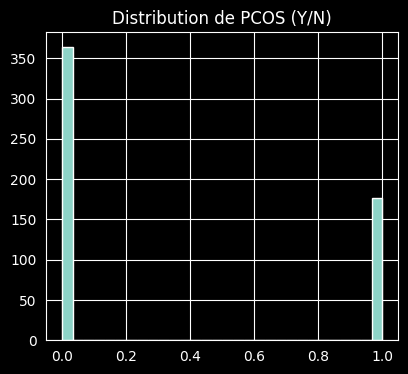

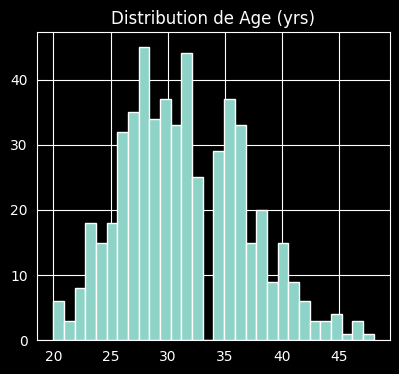

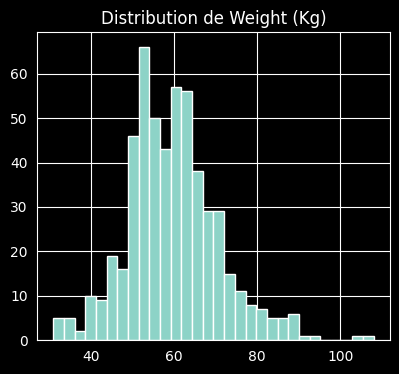

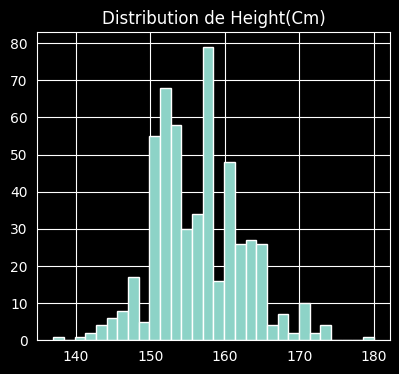

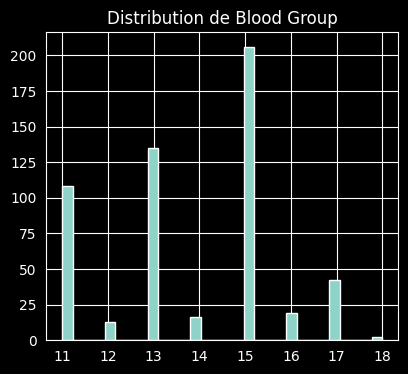

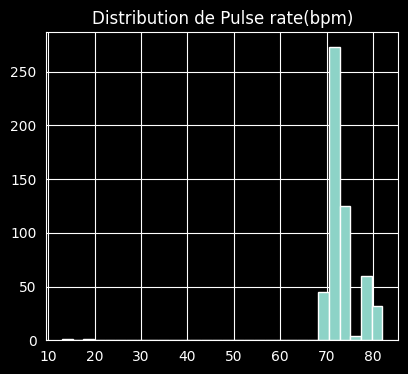

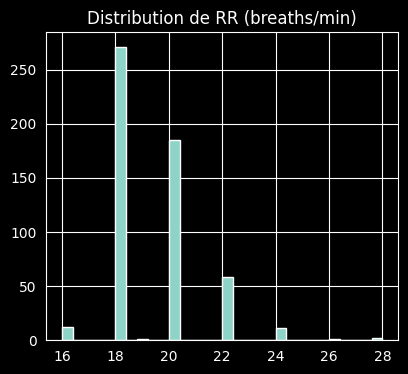

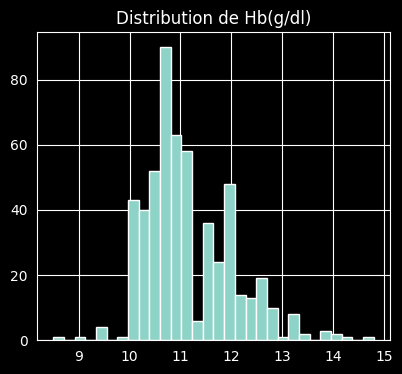

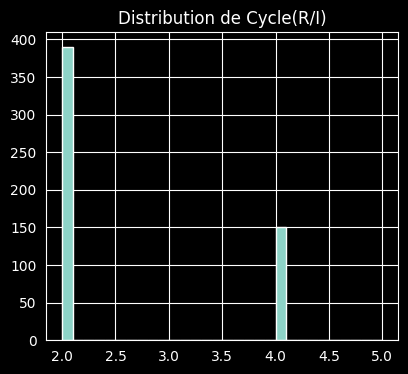

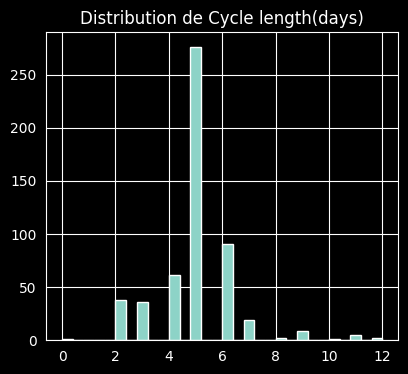

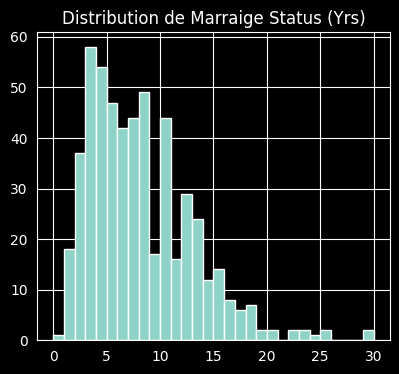

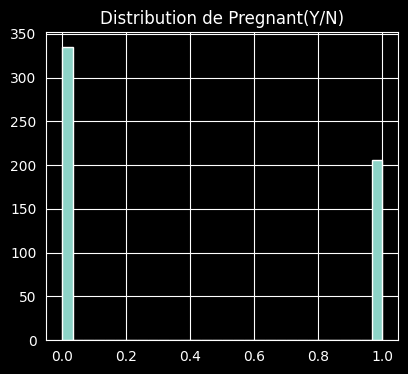

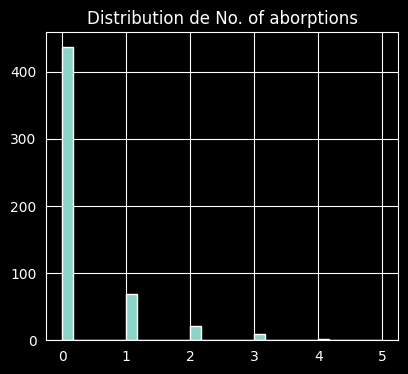

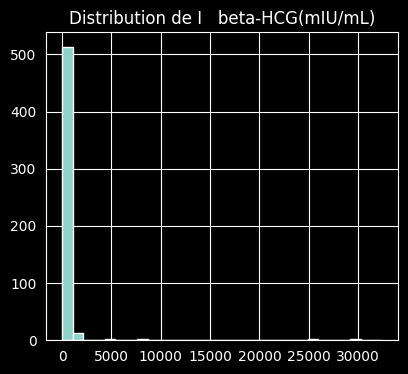

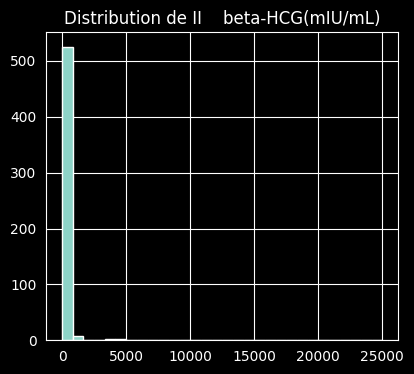

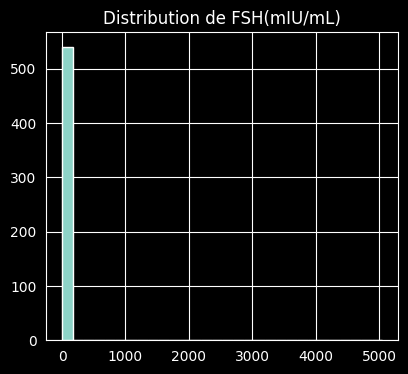

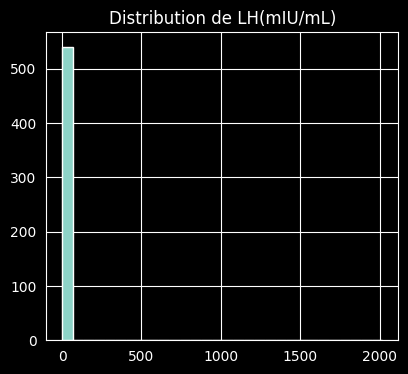

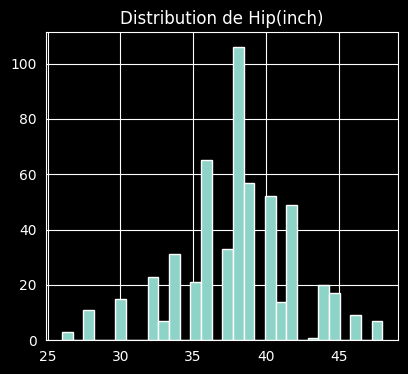

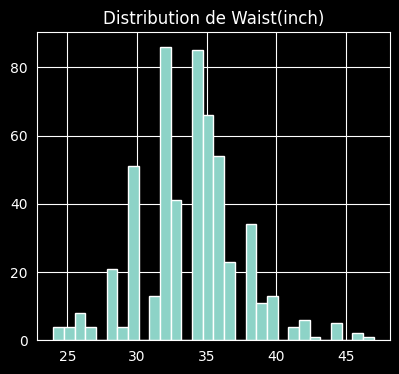

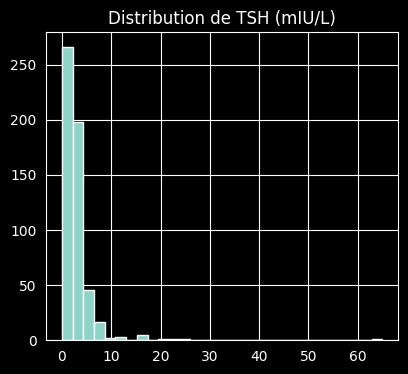

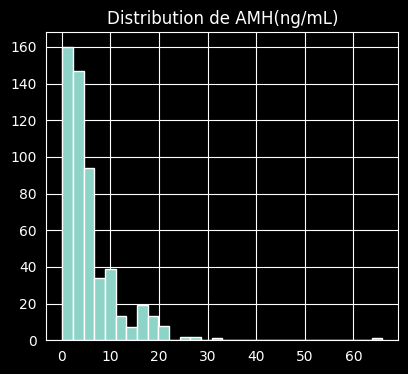

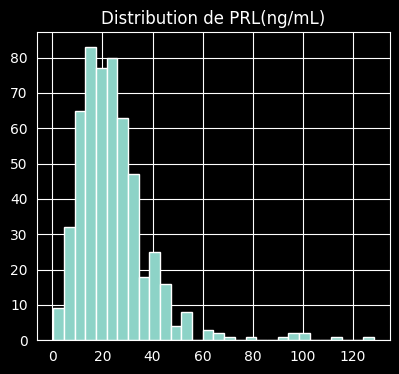

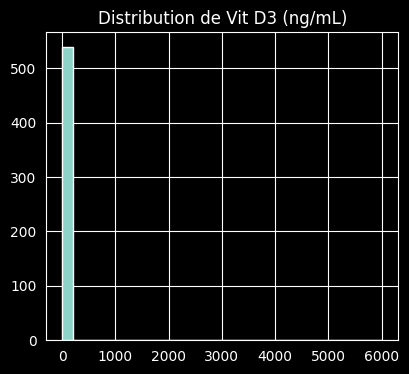

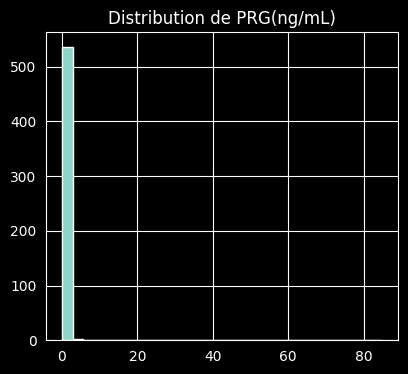

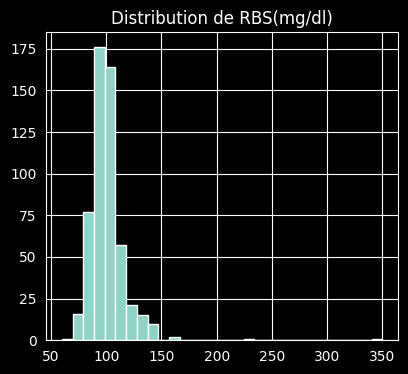

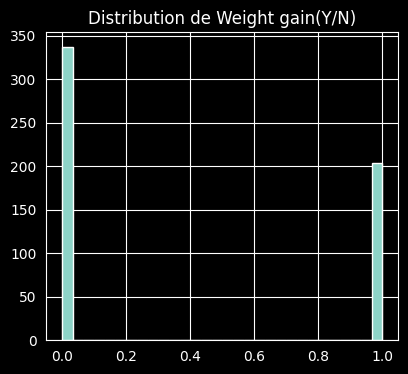

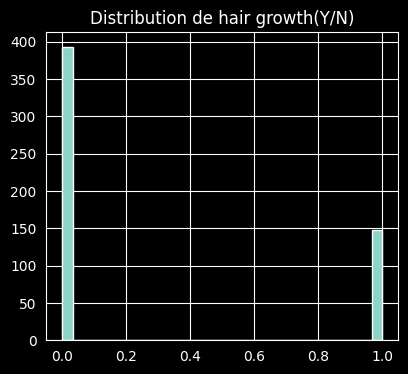

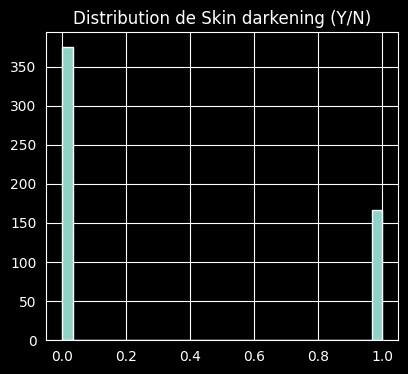

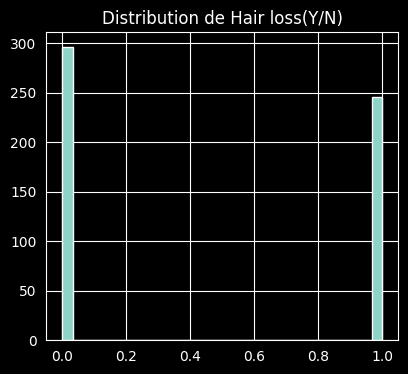

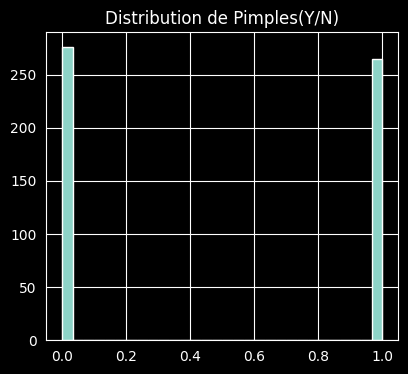

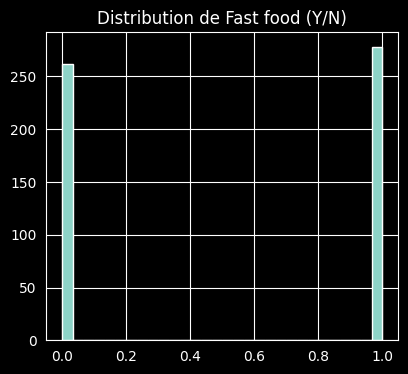

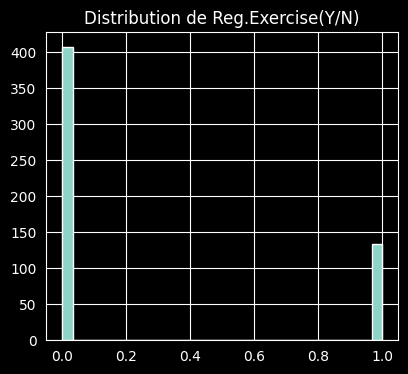

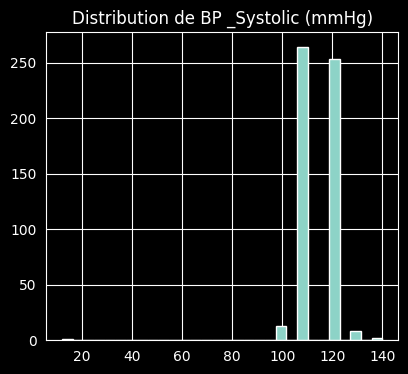

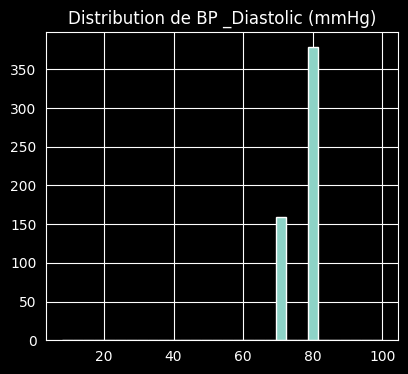

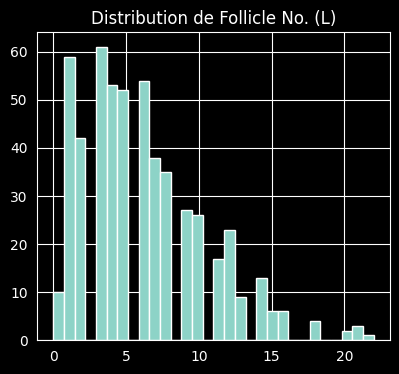

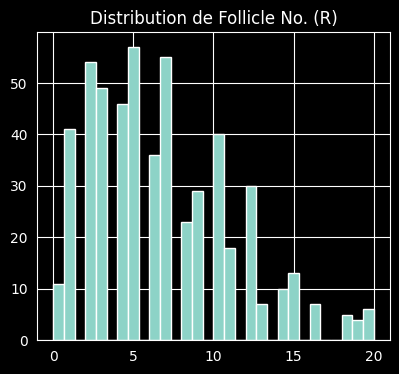

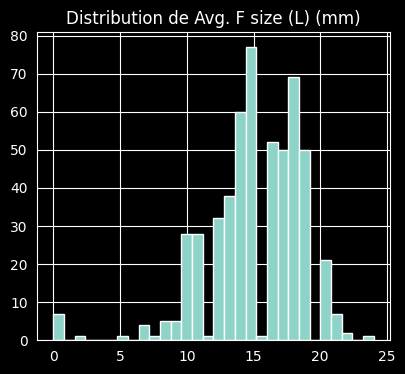

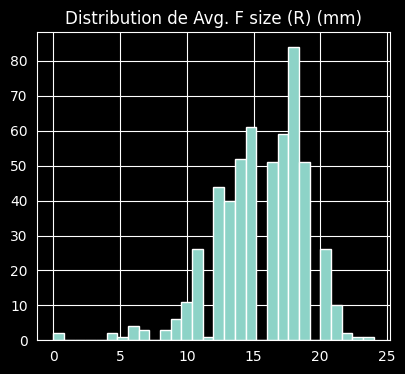

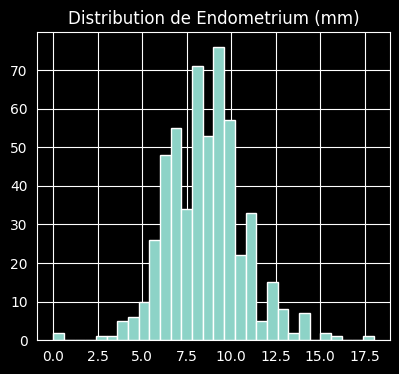

In [1335]:
for col in df.columns:
    plt.figure(figsize=(10, 4))

    # Histogramme
    plt.subplot(1, 2, 1)
    df[col].hist(bins=30)
    plt.title(f'Distribution de {col}')

    plt.show()


In [1336]:
#On vérifie les répartitions des données qui semblent abhérentes
print("Enregistrement avec des pouls très bas")
print(df[df['Pulse rate(bpm)'] < 45]['Pulse rate(bpm)'])
print("Enregistrement avec des BP _Systolic très bas")
print(df[df['BP _Systolic (mmHg)'] <60]['BP _Systolic (mmHg)'])
print("Enregistrement avec des BP _Diastolic (mmHg) très bas")
print(df[df['BP _Diastolic (mmHg)'] <40]['BP _Diastolic (mmHg)'])
print("Enregistrement avec des I beta-HCG très haut")
print(df[df['I   beta-HCG(mIU/mL)'] > 10000]['I   beta-HCG(mIU/mL)'])
print("Enregistrement avec des II beta-HCG très haut")
print(df[df['II    beta-HCG(mIU/mL)'] > 10000]['II    beta-HCG(mIU/mL)'])
print("Enregistrement avec des FSH très haut")
print(df[df['FSH(mIU/mL)'] > 1500]['FSH(mIU/mL)'])
print("Enregistrement avec des LH très haut")
print(df[df['LH(mIU/mL)'] > 750]['LH(mIU/mL)'])
print("Enregistrement avec des TSH très haut")
print(df[df['TSH (mIU/L)'] > 35]['TSH (mIU/L)'])
print("Enregistrement avec des Vit D3 très haut")
print(df[df['Vit D3 (ng/mL)'] > 2000]['Vit D3 (ng/mL)'])
print("Enregistrement avec des PRG très haut")
print(df[df['PRG(ng/mL)'] > 80]['PRG(ng/mL)'])
print("Enregistrement avec des RBS très haut")
print(df[df['RBS(mg/dl)'] > 300]['RBS(mg/dl)'])


Enregistrement avec des pouls très bas
Sl. No
224    18
297    13
Name: Pulse rate(bpm), dtype: int64
Enregistrement avec des BP _Systolic très bas
Sl. No
162    12
Name: BP _Systolic (mmHg), dtype: int64
Enregistrement avec des BP _Diastolic (mmHg) très bas
Sl. No
201    8
Name: BP _Diastolic (mmHg), dtype: int64
Enregistrement avec des I beta-HCG très haut
Sl. No
111    26290.26
112    32460.97
139    21977.29
215    25000.00
253    25000.00
316    21084.21
318    17243.97
447    30004.00
448    30007.00
Name: I   beta-HCG(mIU/mL), dtype: float64
Enregistrement avec des II beta-HCG très haut
Sl. No
139    16069.69
253    25000.00
316    21084.21
Name: II    beta-HCG(mIU/mL), dtype: float64
Enregistrement avec des FSH très haut
Sl. No
330    5052.0
Name: FSH(mIU/mL), dtype: float64
Enregistrement avec des LH très haut
Sl. No
456    2018.0
Name: LH(mIU/mL), dtype: float64
Enregistrement avec des TSH très haut
Sl. No
38    65.0
Name: TSH (mIU/L), dtype: float64
Enregistrement avec des V

Pour tous les enregistrements présentant une ou deux valeurs très écarté de la moyenne, il est très probable que ces valeurs soient des erreurs de saisies ou des cas très marginaux qui risqueraient de fausser les réusltats du modèle. Le fait qu'il s'agit de patient tous différents permet de dire qu'il faut supprimer chaque valeurs particulière et non une ligne entière. Il s'agit de 11 données sur 39*541= 21 099 valeurs, ce nombre est donc négligeables. Pour les colonnes I beta-HCG et II beta-HCG, le nombres d'enregistrement est plus important donc moins succeptibles d'être des erreurs, les données seront donc conservées.

In [1337]:
df.loc[224, 'Pulse rate(bpm)'] = np.nan
df.loc[297, 'Pulse rate(bpm)'] = np.nan
df.loc[162, 'BP _Systolic (mmHg)'] = np.nan
df.loc[201, 'BP _Diastolic (mmHg)'] = np.nan
df.loc[330, 'FSH(mIU/mL)'] = np.nan
df.loc[456, 'LH(mIU/mL)'] = np.nan
df.loc[38, 'TSH (mIU/L)'] = np.nan
df.loc[192, 'Vit D3 (ng/mL)'] = np.nan
df.loc[196, 'Vit D3 (ng/mL)'] = np.nan
df.loc[42, 'PRG(ng/mL)'] = np.nan
df.loc[179, 'RBS(mg/dl)'] = np.nan



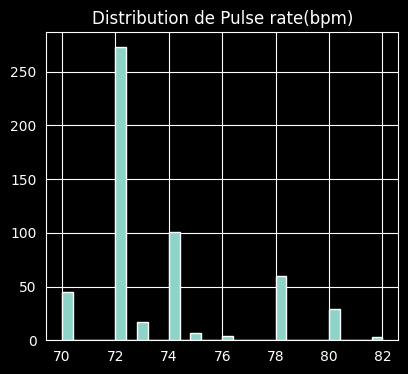

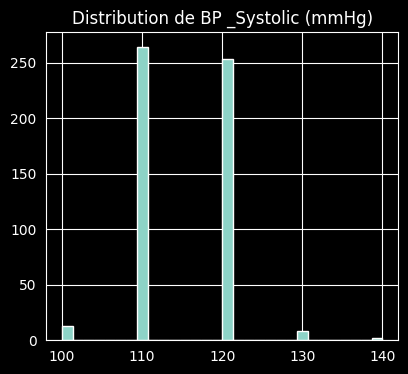

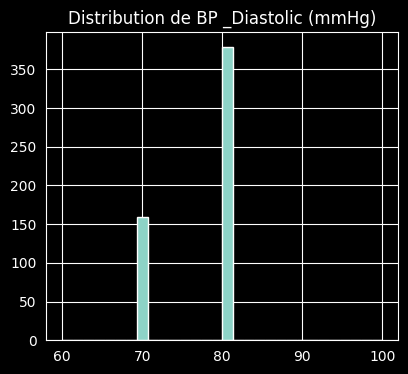

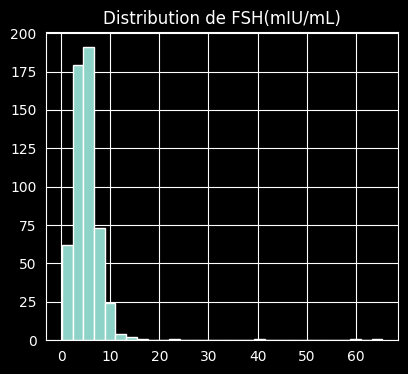

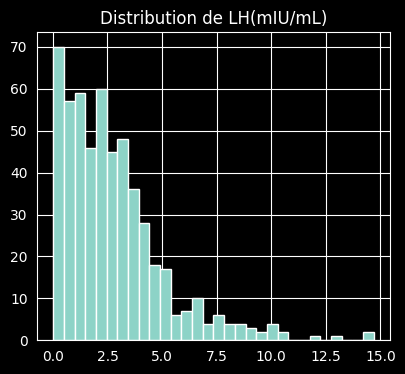

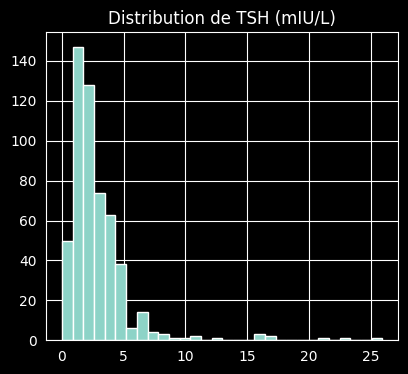

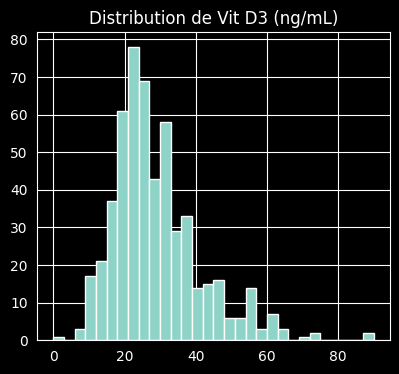

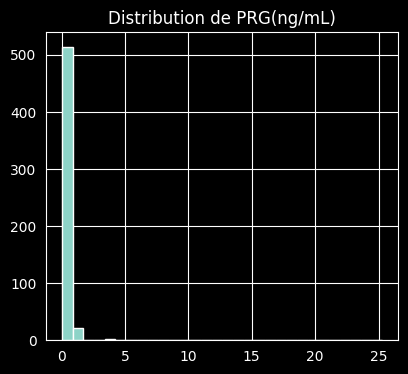

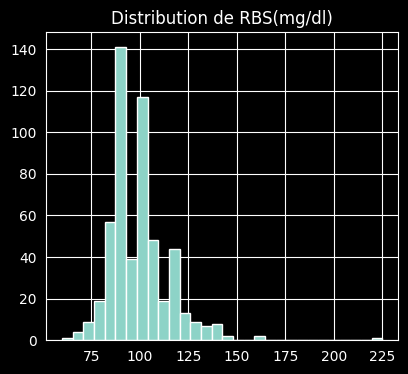

In [1338]:
for col in ['Pulse rate(bpm)','BP _Systolic (mmHg)','BP _Diastolic (mmHg)','FSH(mIU/mL)','LH(mIU/mL)','TSH (mIU/L)','Vit D3 (ng/mL)','PRG(ng/mL)','RBS(mg/dl)']:
    plt.figure(figsize=(10, 4))

    # Histogramme
    plt.subplot(1, 2, 1)
    df[col].hist(bins=30)
    plt.title(f'Distribution de {col}')

    plt.show()

Les distributions sont beaucoup plus standard, le nettoyage a fonctionné

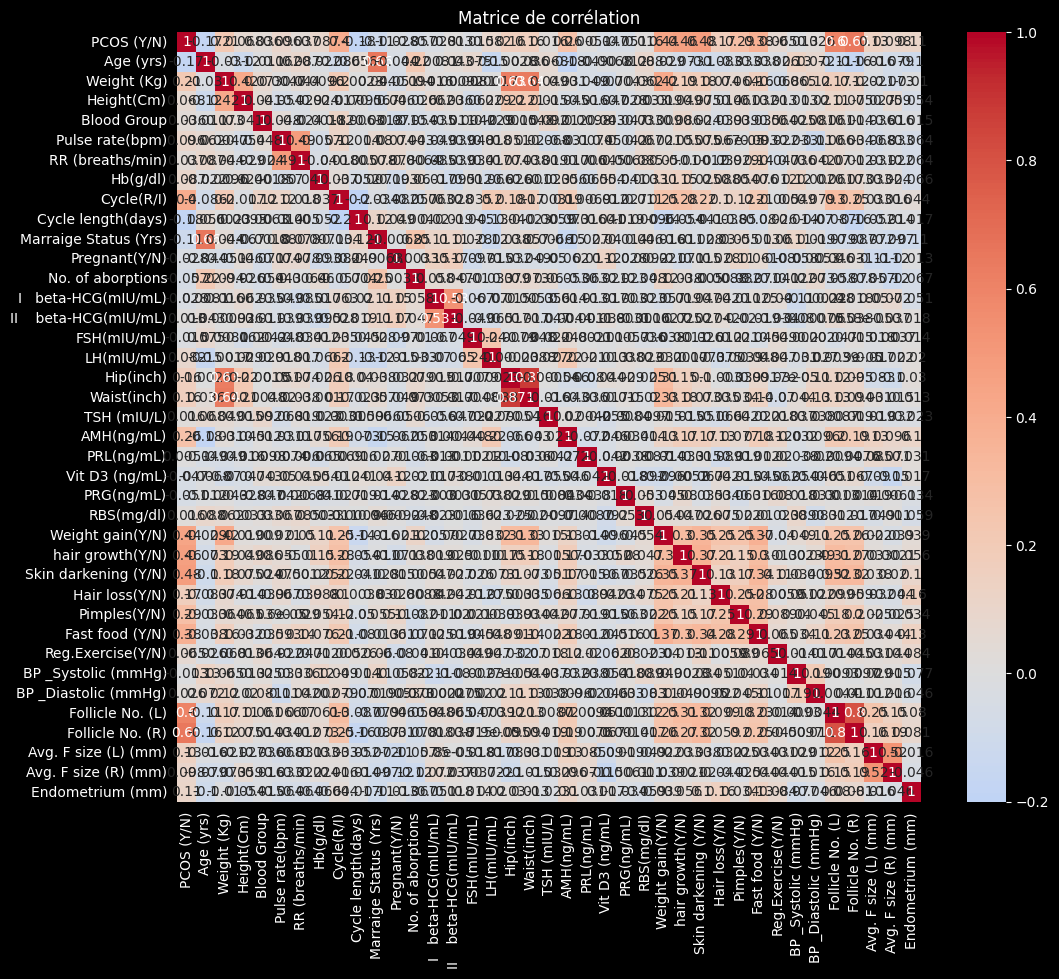

In [1339]:
# Corrélation entre variables numériques
correlation_matrix = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice de corrélation')
plt.show()

Le nombre de colonnes est trop grand pour avoir une matrice de correlation significative, le problème de redondance des colonnes sera traité par la suite lors de l'optimisation du modèle

In [1340]:
# Variables constantes ou quasi-constantes
for col in df.columns:
    unique_ratio = df[col].nunique() / len(df)
    if unique_ratio < 0.01:  # Moins de 1% de valeurs uniques
        print(f"{col}: {unique_ratio:.2%} de valeurs uniques")

PCOS (Y/N): 0.37% de valeurs uniques
Cycle(R/I): 0.55% de valeurs uniques
Pregnant(Y/N): 0.37% de valeurs uniques
Weight gain(Y/N): 0.37% de valeurs uniques
hair growth(Y/N): 0.37% de valeurs uniques
Skin darkening (Y/N): 0.37% de valeurs uniques
Hair loss(Y/N): 0.37% de valeurs uniques
Pimples(Y/N): 0.37% de valeurs uniques
Fast food (Y/N): 0.37% de valeurs uniques
Reg.Exercise(Y/N): 0.37% de valeurs uniques
BP _Systolic (mmHg): 0.92% de valeurs uniques
BP _Diastolic (mmHg): 0.74% de valeurs uniques


Les colonnes remontées sont toutes de type entière avec une grande majorité de oui/non qui par essences sont très redondantes et de valeurs avec des faibles amplitudes donc de ce point de vue là, aucune erreur à signalé.

# IMPUTATION DES VALEURS MANQUANTES

Valeurs manquantes totales:
15
Valeurs manquantes par colonne :
PCOS (Y/N)                0
Age (yrs)                 0
Weight (Kg)               0
Height(Cm)                0
Blood Group               0
Pulse rate(bpm)           2
RR (breaths/min)          0
Hb(g/dl)                  0
Cycle(R/I)                0
Cycle length(days)        0
Marraige Status (Yrs)     1
Pregnant(Y/N)             0
No. of aborptions         0
I   beta-HCG(mIU/mL)      0
II    beta-HCG(mIU/mL)    1
FSH(mIU/mL)               1
LH(mIU/mL)                1
Hip(inch)                 0
Waist(inch)               0
TSH (mIU/L)               1
AMH(ng/mL)                1
PRL(ng/mL)                0
Vit D3 (ng/mL)            2
PRG(ng/mL)                1
RBS(mg/dl)                1
Weight gain(Y/N)          0
hair growth(Y/N)          0
Skin darkening (Y/N)      0
Hair loss(Y/N)            0
Pimples(Y/N)              0
Fast food (Y/N)           1
Reg.Exercise(Y/N)         0
BP _Systolic (mmHg)       1
BP _Diastoli

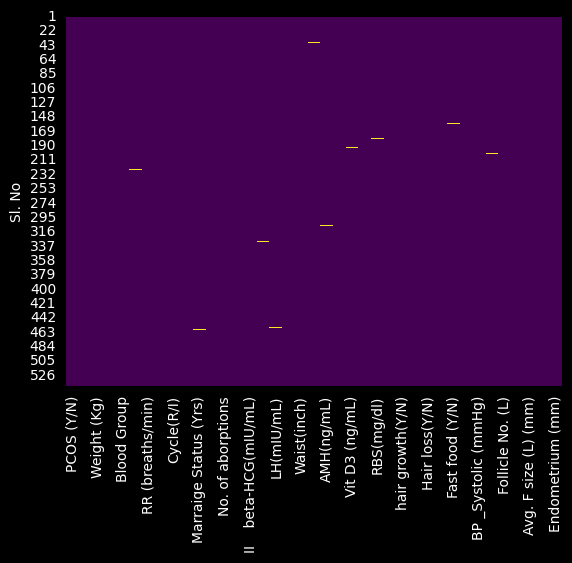

In [1341]:
#vérification des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
print("Valeurs manquantes totales:")
print(df.isnull().sum().sum())
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

In [1342]:
#On utilise la moyenne pour les variables de type float
imputer_mean = SimpleImputer(strategy='mean')
df_imputed = df.copy()
df_imputed[['AMH(ng/mL)','Marraige Status (Yrs)','Pulse rate(bpm)','BP _Systolic (mmHg)','BP _Diastolic (mmHg)','FSH(mIU/mL)','LH(mIU/mL)','TSH (mIU/L)','Vit D3 (ng/mL)','PRG(ng/mL)','RBS(mg/dl)','II    beta-HCG(mIU/mL)']] = imputer_mean.fit_transform(df[['AMH(ng/mL)','Marraige Status (Yrs)','Pulse rate(bpm)','BP _Systolic (mmHg)','BP _Diastolic (mmHg)','FSH(mIU/mL)','LH(mIU/mL)','TSH (mIU/L)','Vit D3 (ng/mL)','PRG(ng/mL)','RBS(mg/dl)','II    beta-HCG(mIU/mL)']])

# On met 0,5 pour le booleéen
imputer_fix = SimpleImputer(strategy='constant', fill_value=0.5)
df_imputed[['Fast food (Y/N)']]=imputer_fix.fit_transform(df[['Fast food (Y/N)']])

In [1343]:
print("Valeurs manquantes totales après imputation:")
print(df_imputed.isnull().sum().sum())

Valeurs manquantes totales après imputation:
0


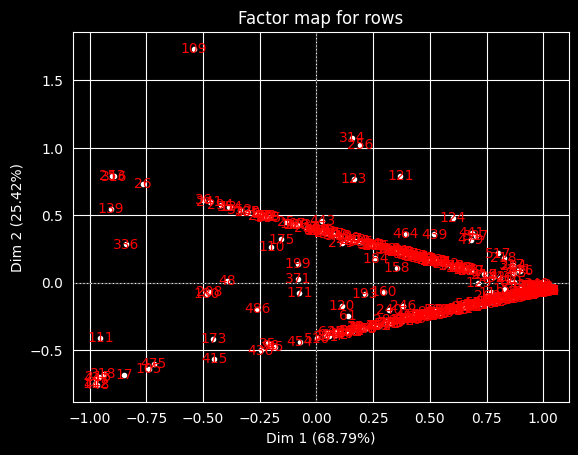

In [1344]:
#AFC : vérification de la répartition des données afin de vérifier si on a pas des données trop margiales après le nettoyage
afc = CA(row_labels=df_imputed.index,col_labels=df_imputed.columns, stats=True)
afc.fit(df_imputed.values)

afc.mapping_row(num_x_axis=1, num_y_axis=2)

On remarque que la ligne 109 (et après suppression du 109, on remarque que le 110 était supperposé au 109 donc il est supprimé aussi) est très à l'écart du reste des données, elle sera supprimé pour limité les biais d'entrainement (après test, si on conserve le 109, la précision et le recall chutent de 0.1 chacun)

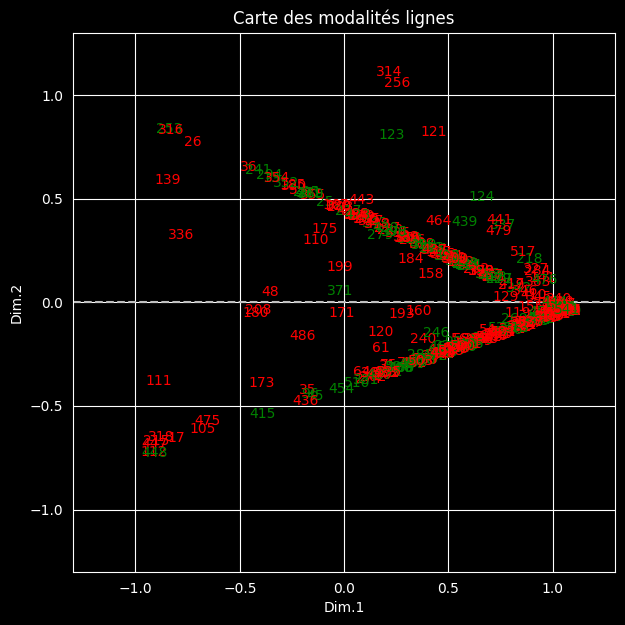

In [1345]:
df_imputed = df_imputed.drop(index=109)

afc = CA(row_labels=df_imputed.index,col_labels=df_imputed.columns, stats=True)
afc.fit(df_imputed.values)

#affichage plus propre
coord_lig = afc.row_coord_[:,:2]
fig, ax = plt.subplots(figsize=(7,7))
ax.axis([-1.3,+1.3,-1.3,+1.3])
ax.plot([-1.3,+1.3],[0,0],color='silver',linestyle='--')
ax.plot([0,0],[1.3,+1.3],color='silver',linestyle='--')
ax.set_xlabel("Dim.1")
ax.set_ylabel("Dim.2")
plt.title("Carte des modalités lignes")
for i in range(df_imputed.shape[0]):
    color = 'green' if df_imputed['PCOS (Y/N)'].iloc[i] == 1 else 'red'
    ax.text(coord_lig[i,0],coord_lig[i,1],df_imputed.index[i],  color=color)

plt.show()

Les données sont maintenant propres, on va pouvoir commencer le travial sur les modèles

# CHOIX DU TYPE DE MODELE

## Standardisation

In [1346]:
Y = df_imputed['PCOS (Y/N)']
X = df_imputed.drop('PCOS (Y/N)', axis=1)

scaler = StandardScaler()
x_train_means, x_test_means, y_train_means, y_test_means = train_test_split(X, Y, test_size=0.25, random_state=42)

x_train_means = scaler.fit_transform(x_train_means)
x_test_means = scaler.fit_transform(x_test_means)


In [1347]:
def showResult(nom_modele,y_train,y_test,y_pred_train_modele,y_pred_test_modele):
    print(f"RESULTAT {nom_modele}")
    print(f'Accuracy sur le jeu d\'entraînement : {str(accuracy_score(y_train,y_pred_train_modele))}')
    print(f'Recall sur le jeu d\'entraînement : {str(recall_score(y_train,y_pred_train_modele))}')
    print(f'Accuracy sur le jeu de test : {str(accuracy_score(y_test,y_pred_test_modele))}')
    print(f'Recall sur le jeu de test : {str(recall_score(y_test,y_pred_test_modele))}')

def showMatriceCorrelation(y_train,y_test,y_pred_train_modele,y_pred_test_modele):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    cm_train = confusion_matrix(y_train, y_pred_train_modele)
    cm_test = confusion_matrix(y_test, y_pred_test_modele)
    ConfusionMatrixDisplay(cm_train, display_labels=['Pas malade', 'Malade']).plot(ax=axes[0], cmap='Greens')
    axes[0].set_title(f'Matrice de Confusion - Train')

    ConfusionMatrixDisplay(cm_test, display_labels=['Pas malade', 'Malade']).plot(ax=axes[1], cmap='Blues')
    axes[1].set_title(f'Matrice de Confusion - Test')

## Regression logistique

In [1348]:
log_reg= LogisticRegression()
log_reg.fit(x_train_means, y_train_means)
y_pred_train_reg = log_reg.predict(x_train_means)
y_pred_test_reg = log_reg.predict(x_test_means)

In [1349]:
showResult(REGRESSION_LOGISTIQUE,y_train_means,y_test_means,y_pred_train_reg,y_pred_test_reg)

RESULTAT REGRESSION LOGISTIQUE
Accuracy sur le jeu d'entraînement : 0.9308641975308642
Recall sur le jeu d'entraînement : 0.8582089552238806
Accuracy sur le jeu de test : 0.8666666666666667
Recall sur le jeu de test : 0.8095238095238095


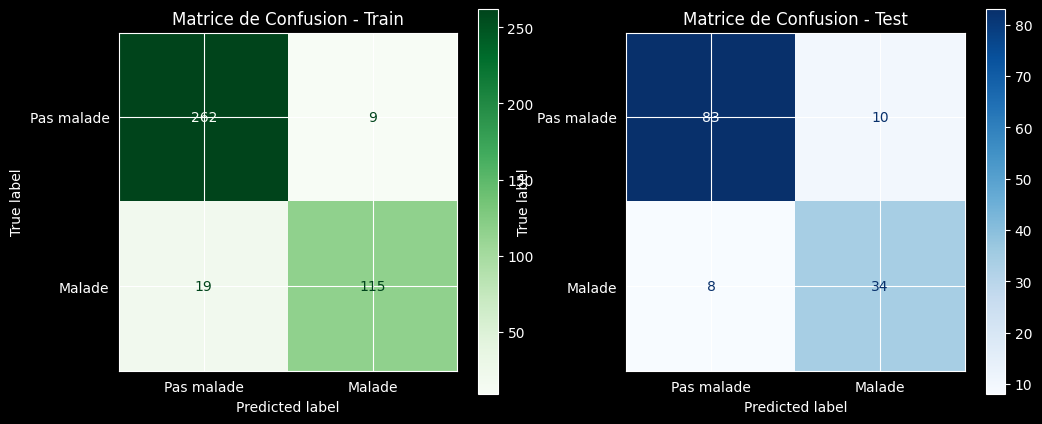

In [1350]:
showMatriceCorrelation(y_train_means,y_test_means,y_pred_train_reg,y_pred_test_reg)

## Arbre de décision

[Text(0.6036585365853658, 0.95, 'x[34] <= 0.392\nentropy = 0.916\nsamples = 405\nvalue = [271, 134]'),
 Text(0.36585365853658536, 0.85, 'x[25] <= 0.521\nentropy = 0.556\nsamples = 278\nvalue = [242, 36]'),
 Text(0.4847560975609756, 0.8999999999999999, 'True  '),
 Text(0.17073170731707318, 0.75, 'x[19] <= 0.168\nentropy = 0.341\nsamples = 221\nvalue = [207, 14]'),
 Text(0.07317073170731707, 0.65, 'x[33] <= -0.167\nentropy = 0.154\nsamples = 180\nvalue = [176, 4]'),
 Text(0.04878048780487805, 0.55, 'entropy = 0.0\nsamples = 137\nvalue = [137, 0]'),
 Text(0.0975609756097561, 0.55, 'x[0] <= -1.096\nentropy = 0.446\nsamples = 43\nvalue = [39, 4]'),
 Text(0.04878048780487805, 0.45, 'x[19] <= -0.411\nentropy = 0.985\nsamples = 7\nvalue = [4, 3]'),
 Text(0.024390243902439025, 0.35, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.07317073170731707, 0.35, 'entropy = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.14634146341463414, 0.45, 'x[15] <= 1.455\nentropy = 0.183\nsamples = 36\nvalue =

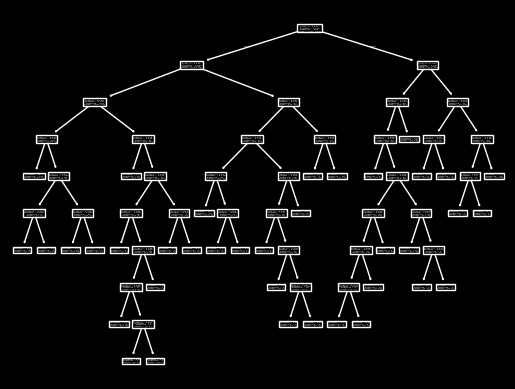

In [1351]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy')
clf = clf.fit(x_train_means,y_train_means)
y_pred_train_arbre = clf.predict(x_train_means)
y_pred_test_arbre = clf.predict(x_test_means)
tree.plot_tree(clf)

In [1352]:
showResult(ARBRE_DECISION,y_train_means,y_test_means,y_pred_train_arbre,y_pred_test_arbre)

RESULTAT ARBRE DE DECISION
Accuracy sur le jeu d'entraînement : 1.0
Recall sur le jeu d'entraînement : 1.0
Accuracy sur le jeu de test : 0.8518518518518519
Recall sur le jeu de test : 0.7857142857142857


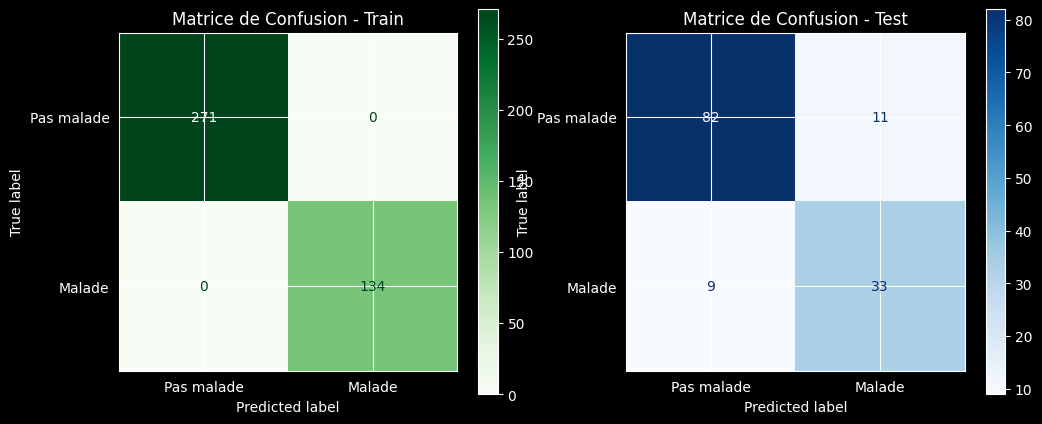

In [1353]:
showMatriceCorrelation(y_train_means,y_test_means,y_pred_train_arbre,y_pred_test_arbre)

## Support Vecteur Machine

In [1354]:
svm = SVC()
svm.fit(x_train_means, y_train_means)
y_pred_train_svm = svm.predict(x_train_means)
y_pred_test_svm = svm.predict(x_test_means)

In [1355]:
showResult(SVM,y_train_means,y_test_means, y_pred_train_svm, y_pred_test_svm)

RESULTAT SUPPORT VECTEUR MACHINE
Accuracy sur le jeu d'entraînement : 0.9703703703703703
Recall sur le jeu d'entraînement : 0.9253731343283582
Accuracy sur le jeu de test : 0.8814814814814815
Recall sur le jeu de test : 0.7380952380952381


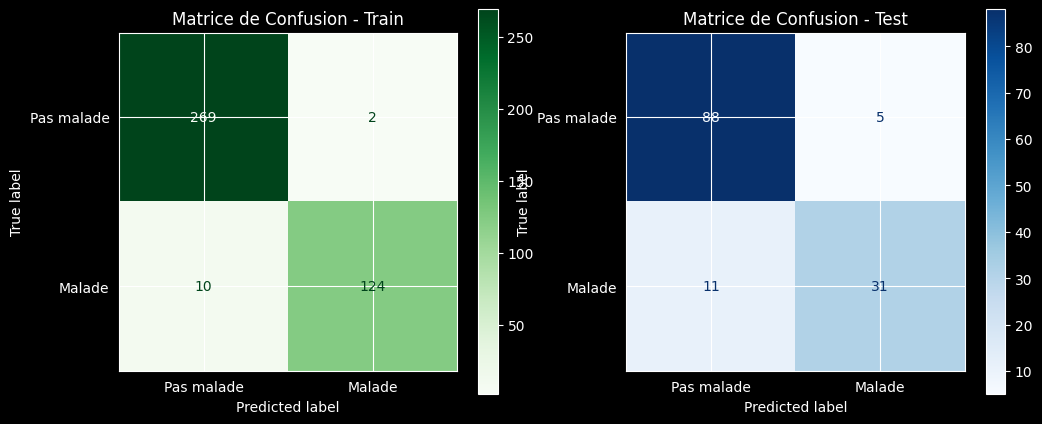

In [1356]:
showMatriceCorrelation(y_train_means,y_test_means,y_pred_train_svm,y_pred_test_svm)

Conclusion : Pour l'instant le modèle qui semble le plus intéressant est la regression logisitque, avec un équilibre correcte entre la precision et le recall. L'arbre de décision montre clairement des signes de sur-entrainement

# Suppression des colonnes surnuméraires

In [1357]:
#Le nombre important de colonnes qui peuvent être fortement correlés entre elles peut limiter les performances d'apprentissage on essaye donc de reduire le nombre pour voir si les performances sont améliorées

knn = KNeighborsClassifier(n_neighbors=5)

sfs = SequentialFeatureSelector(knn, n_features_to_select=30, direction='forward', cv=5)
sfs.fit(x_train_means, y_train_means)

features_selectionnees = X.columns[sfs.get_support()].tolist()
features_redondantes = X.columns[~sfs.get_support()].tolist()

print("Features sélectionnées :", features_selectionnees)
print("Features redondantes :", features_redondantes)

Features sélectionnées : ['Age (yrs)', 'Weight (Kg)', 'Height(Cm)', 'Pulse rate(bpm)', 'RR (breaths/min)', 'Hb(g/dl)', 'Cycle(R/I)', 'Marraige Status (Yrs)', 'Pregnant(Y/N)', 'No. of aborptions', 'I   beta-HCG(mIU/mL)', 'II    beta-HCG(mIU/mL)', 'FSH(mIU/mL)', 'LH(mIU/mL)', 'Hip(inch)', 'TSH (mIU/L)', 'AMH(ng/mL)', 'PRL(ng/mL)', 'PRG(ng/mL)', 'RBS(mg/dl)', 'Weight gain(Y/N)', 'hair growth(Y/N)', 'Skin darkening (Y/N)', 'Hair loss(Y/N)', 'Reg.Exercise(Y/N)', 'Follicle No. (L)', 'Follicle No. (R)', 'Avg. F size (L) (mm)', 'Avg. F size (R) (mm)', 'Endometrium (mm)']
Features redondantes : ['Blood Group', 'Cycle length(days)', 'Waist(inch)', 'Vit D3 (ng/mL)', 'Pimples(Y/N)', 'Fast food (Y/N)', 'BP _Systolic (mmHg)', 'BP _Diastolic (mmHg)']


In [1358]:
df_reduced= df_imputed[features_selectionnees]

df_reduced

,Age (yrs),Weight (Kg),Height(Cm),Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Marraige Status (Yrs),Pregnant(Y/N),No. of aborptions,...,Weight gain(Y/N),hair growth(Y/N),Skin darkening (Y/N),Hair loss(Y/N),Reg.Exercise(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
Sl. No,,,,,,,,,,,,,,,,,,,,,
1,28,44.6,152.000,78.0,22,10.48,2,7.0,0,0,...,0,0,0,0,0,3,3,18.0,18.0,8.5
2,36,65.0,161.500,74.0,20,11.70,2,11.0,1,0,...,0,0,0,0,0,3,5,15.0,14.0,3.7
3,33,68.8,165.000,72.0,18,11.80,2,10.0,1,0,...,0,0,0,1,0,13,15,18.0,20.0,10.0
4,37,65.0,148.000,72.0,20,12.00,2,4.0,0,0,...,0,0,0,0,0,2,2,15.0,14.0,7.5
5,25,52.0,161.000,72.0,18,10.00,2,1.0,1,0,...,0,0,0,1,0,3,4,16.0,14.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,35,50.0,164.592,72.0,16,11.00,2,8.0,0,1,...,0,0,0,0,0,1,0,17.5,10.0,6.7
538,30,63.2,158.000,72.0,18,10.80,2,4.0,1,1,...,1,0,0,0,0,9,7,19.0,18.0,8.2
539,36,54.0,152.000,74.0,20,10.80,2,8.0,0,0,...,0,0,0,0,0,1,0,18.0,9.0,7.3


In [1359]:

x_train_red, x_test_red, y_train_red, y_test_red = train_test_split(df_reduced, Y, test_size=0.25, random_state=42)
x_train_red = scaler.fit_transform(x_train_red)
x_test_red = scaler.fit_transform(x_test_red)

In [1360]:
log_reg_red= LogisticRegression()
log_reg_red= log_reg_red.fit(x_train_red, y_train_red)
y_pred_train_red_reg = log_reg_red.predict(x_train_red)
y_pred_test_red_reg = log_reg_red.predict(x_test_red)

In [1361]:
showResult(REGRESSION_LOGISTIQUE,y_train_red,y_test_red,y_pred_train_red_reg,y_pred_test_red_reg)

RESULTAT REGRESSION LOGISTIQUE
Accuracy sur le jeu d'entraînement : 0.9308641975308642
Recall sur le jeu d'entraînement : 0.8731343283582089
Accuracy sur le jeu de test : 0.8740740740740741
Recall sur le jeu de test : 0.8333333333333334


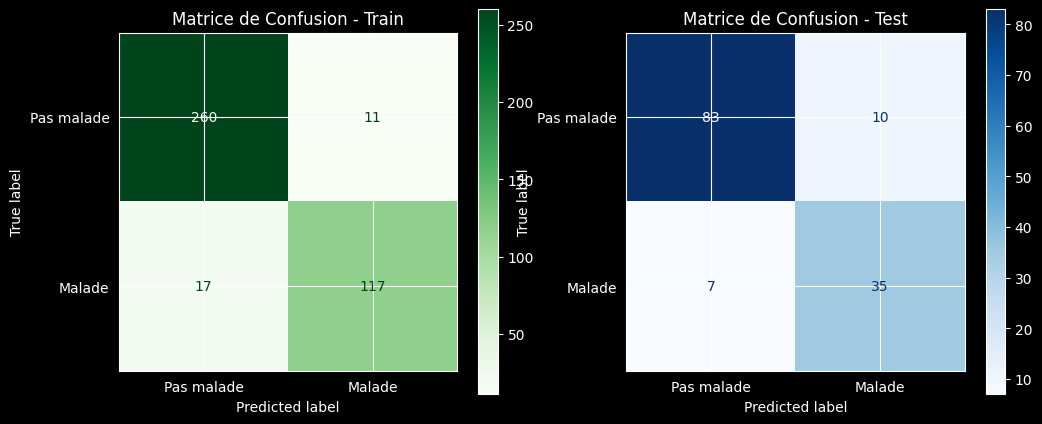

In [1362]:
showMatriceCorrelation(y_train_red,y_test_red,y_pred_train_red_reg,y_pred_test_red_reg)

[Text(0.5416666666666666, 0.9166666666666666, 'x[26] <= 0.392\nentropy = 0.916\nsamples = 405\nvalue = [271, 134]'),
 Text(0.3, 0.75, 'x[21] <= 0.521\nentropy = 0.556\nsamples = 278\nvalue = [242, 36]'),
 Text(0.4208333333333333, 0.8333333333333333, 'True  '),
 Text(0.13333333333333333, 0.5833333333333334, 'x[16] <= 0.168\nentropy = 0.341\nsamples = 221\nvalue = [207, 14]'),
 Text(0.06666666666666667, 0.4166666666666667, 'x[25] <= -0.167\nentropy = 0.154\nsamples = 180\nvalue = [176, 4]'),
 Text(0.03333333333333333, 0.25, 'entropy = 0.0\nsamples = 137\nvalue = [137, 0]'),
 Text(0.1, 0.25, 'x[6] <= 0.507\nentropy = 0.446\nsamples = 43\nvalue = [39, 4]'),
 Text(0.06666666666666667, 0.08333333333333333, 'entropy = 0.183\nsamples = 36\nvalue = [35, 1]'),
 Text(0.13333333333333333, 0.08333333333333333, 'entropy = 0.985\nsamples = 7\nvalue = [4, 3]'),
 Text(0.2, 0.4166666666666667, 'x[28] <= -0.305\nentropy = 0.801\nsamples = 41\nvalue = [31, 10]'),
 Text(0.16666666666666666, 0.25, 'entropy 

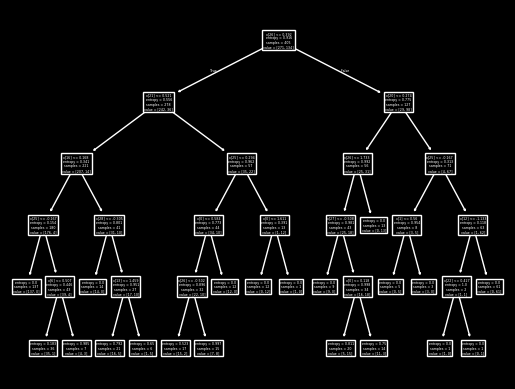

In [1363]:
#On rajoute une profondeur max pour limiter le surapprentissage
clf_red = tree.DecisionTreeClassifier(criterion = 'entropy',max_depth=5)
clf_red = clf_red.fit(x_train_red, y_train_red)
y_pred_train_red_arbre = clf_red.predict(x_train_red)
y_pred_test_red_arbre = clf_red.predict(x_test_red)
tree.plot_tree(clf_red)

In [1364]:
showResult(ARBRE_DECISION,y_train_red,y_test_red,y_pred_train_red_arbre,y_pred_test_red_arbre)

RESULTAT ARBRE DE DECISION
Accuracy sur le jeu d'entraînement : 0.9333333333333333
Recall sur le jeu d'entraînement : 0.8955223880597015
Accuracy sur le jeu de test : 0.8148148148148148
Recall sur le jeu de test : 0.7142857142857143


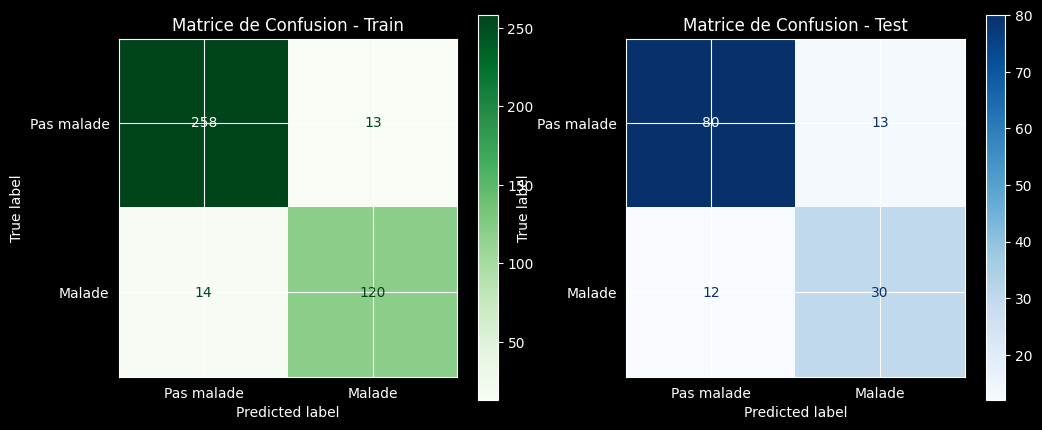

In [1365]:
showMatriceCorrelation(y_train_red,y_test_red,y_pred_train_red_arbre,y_pred_test_red_arbre)

In [1366]:
svm_red = SVC()
svm_red=svm_red.fit(x_train_red, y_train_red)
y_pred_train_svm = svm_red.predict(x_train_red)
y_pred_test_svm = svm_red.predict(x_test_red)

In [1367]:
showResult(SVM,y_train_red,y_test_red,y_pred_train_svm,y_pred_test_svm)

RESULTAT SUPPORT VECTEUR MACHINE
Accuracy sur le jeu d'entraînement : 0.9604938271604938
Recall sur le jeu d'entraînement : 0.9029850746268657
Accuracy sur le jeu de test : 0.8814814814814815
Recall sur le jeu de test : 0.7857142857142857


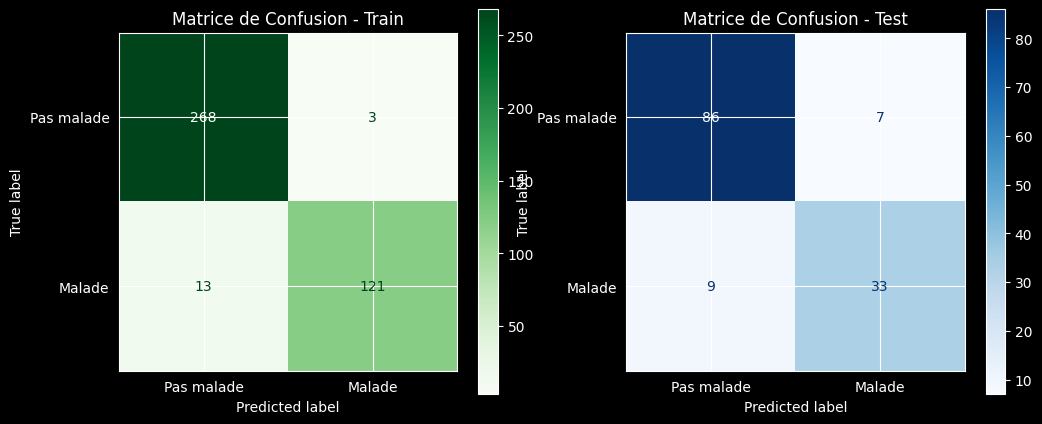

In [1368]:
showMatriceCorrelation(y_train_red,y_test_red,y_pred_train_svm,y_pred_test_svm)

Resultat : Les tests ont été fait avec des valeurs entre 15 lignes conservés et 35 lignes conservées. Le nombre de ligne conservé avait un impact différents sur les différents type de modèle.

Le choix du modèle final se porte sur la regression logistique qui est le modèle qui a le meilleur recall (très important dans le cas d'un logiciel de diagnostique)

Le meilleur nombre de colonne à conservé pour ce modèle est : 30

# Choix des Hyperparamètres

In [1369]:
#On va avoir des warning à cause desconfiguration croisées qui ne sont pas optimal donc on les supprime pour une meilleur lisibilité du notebook
warnings.simplefilter('ignore')

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, np.inf],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
    'solver': ['liblinear','saga'],
    'max_iter': [50,150,250,500, 1000, 2000,5000],
    'class_weight': [None, 'balanced']
}

log_reg_optimiser = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=log_reg_optimiser,
    param_grid=param_grid,
    cv=7,
    scoring='f1'
)
#Test avec scoring = recall ==> les performances de précision descendaient en dessous de 0,8 pour un gain de recall pas significatif
grid_search.fit(x_train_red, y_train_red)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",LogisticRegre...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'C': [0.001, 0.01, ...], 'class_weight': [None, 'balanced'], 'l1_ratio': [0, 0.25, ...], 'max_iter': [50, 150, ...], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",7
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and paramete

In [1370]:
print("MEILLEURS HYPERPARAMÈTRES")
print(grid_search.best_params_)

MEILLEURS HYPERPARAMÈTRES
{'C': 0.1, 'class_weight': None, 'l1_ratio': 1, 'max_iter': 50, 'solver': 'liblinear'}


In [1371]:
log_reg_best = grid_search.best_estimator_
y_pred_train_best = log_reg_best.predict(x_train_red)
y_pred_test_best = log_reg_best.predict(x_test_red)

In [1372]:
showResult(REGRESSION_LOGISTIQUE,y_train_red,y_test_red,y_pred_train_best,y_pred_test_best)

RESULTAT REGRESSION LOGISTIQUE
Accuracy sur le jeu d'entraînement : 0.9259259259259259
Recall sur le jeu d'entraînement : 0.8731343283582089
Accuracy sur le jeu de test : 0.8962962962962963
Recall sur le jeu de test : 0.8571428571428571


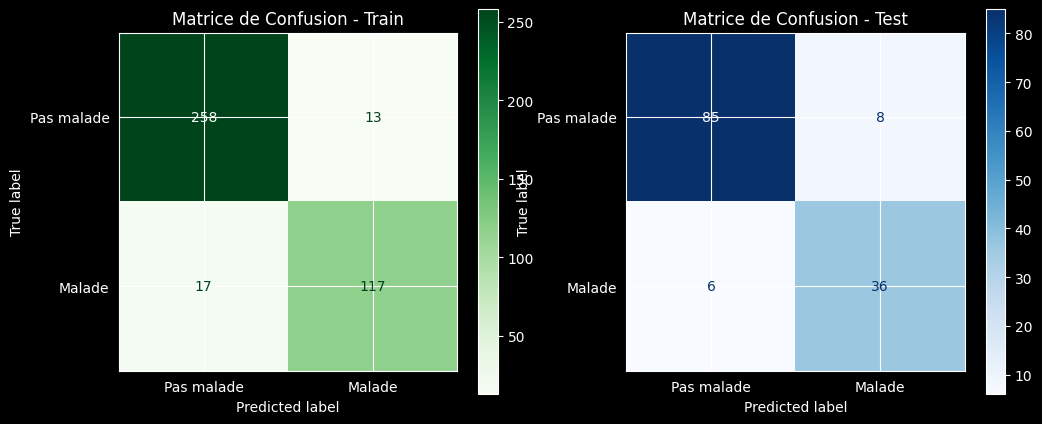

In [1373]:
showMatriceCorrelation(y_train_red,y_test_red,y_pred_train_best,y_pred_test_best)

# CREATION D'UN PIPELINE

In [1374]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic', grid_search.best_estimator_)
])
x_train_pi, x_test_pi, y_train_pi, y_test_pi = train_test_split(df_reduced, Y, test_size=0.25, random_state=42)
pipeline.fit(x_train_pi, y_train_pi)
y_pred_train_pi = pipeline.predict(x_train_pi)
y_pred_test_pi = pipeline.predict(x_test_pi)

# SAUVEGARDE DU MODELE

In [1375]:
joblib.dump(pipeline, 'pipeline_complet.pkl')

['pipeline_complet.pkl']